In [1]:
import numpy
import pandas
import re
import seaborn
import time
import torch
import torch.nn as nn
from matplotlib import pyplot
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, Dataset
from typing import Any

In [2]:
training_data_frame = pandas.read_csv('datasets/twitter_training.csv', names=['id','entity','label','tweet'])
testing_data_frame = pandas.read_csv('datasets/twitter_validation.csv', names=['id','entity','label','tweet'])

print('The shape of the training data frame: ' + str(training_data_frame.shape))
print('The shape of the testing data frame: ' + str(testing_data_frame.shape))

training_data_frame = training_data_frame[['label', 'tweet']]
testing_data_frame = testing_data_frame[['label', 'tweet']]

training_data_frame['tokens_count'] = training_data_frame['tweet'].apply(lambda text: len(str(text).split(' ')))
testing_data_frame['tokens_count'] = testing_data_frame['tweet'].apply(lambda text: len(str(text).split(' ')))

print('The description for the training data frame:')
print(training_data_frame.describe())
print('The description for the training data frame:')
print(testing_data_frame.describe())

The shape of the training data frame: (74682, 4)
The shape of the testing data frame: (1000, 4)


The description for the training data frame:
         TokenCount
count  74682.000000
mean      19.237340
std       14.502922
min        1.000000
25%        8.000000
50%       16.000000
75%       27.000000
max      198.000000


The description for the training data frame:
        TokenCount
count  1000.000000
mean     20.701000
std      13.354023
min       1.000000
25%      10.000000
50%      17.000000
75%      31.000000
max      57.000000




In [3]:
def add_padding_to_text(text, needed_length):
    result_text = numpy.zeros(needed_length, dtype=numpy.int64)

    if len(text) > needed_length:
        result_text[:] = text[:needed_length]
    else:
        result_text[:len(text)] = text

    return result_text

def clear_punctuation_signs(text):
    text = re.sub(r'[\'#$%&\'@_`~]', r'', text)
    text = re.sub(r'[!\\()*+,-./:;<=>?\[\]^{|}]', r' ', text)
    text = text.strip()
    text = text.replace('\n', ' ')

    return text

def filter_non_alphabetic_chars(text):
    alphabetic_text = ''

    for word in text.split():
        alphabetic_word = re.sub('[^a-z A-Z]+', '', word)
        alphabetic_text += alphabetic_word
        alphabetic_text += ' '

    alphabetic_text = alphabetic_text.strip()

    return alphabetic_text


def remove_repeated_chars(text):
    return re.sub(r'(\w)(\1{2,})', r'\1', text)

def remove_stopwords(text):
    stop_word = set(stopwords.words('english'))
    re_stop_words = re.compile(r'\b(' + '|'.join(stopwords.words('english')) + ')\\W', re.I)

    return re_stop_words.sub('', text)

def process_the_text(text):
    text = str(text).lower()
    text = clear_punctuation_signs(text)
    text = filter_non_alphabetic_chars(text)
    text = remove_repeated_chars(text)
    text = remove_stopwords(text)

    return text

In [4]:
training_data_frame = training_data_frame.loc[training_data_frame['tokens_count'] < 60]
testing_data_frame = testing_data_frame.loc[testing_data_frame['tokens_count'] < 60]

training_data_frame = training_data_frame.sample(n=50000)

print(training_data_frame.shape)
print(testing_data_frame.shape)

training_data_frame['tweet'] = training_data_frame['tweet'].apply(process_the_text)
testing_data_frame['tweet'] = testing_data_frame['tweet'].apply(process_the_text)

(50000, 3)
(1000, 3)


In [5]:
class Tweet_Vocabulary:
    
    def __init__(self, word_set):
        self.word2index = {}
        self.index2word = {}
        self.vocab = word_set
        self.create_index()
        
    def create_index(self):
        self.vocab = sorted(self.vocab)

        self.word2index['<padding>'] = 0
        self.index2word[0] = '<padding>'

        for index, word in enumerate(self.vocab):
            self.word2index[word] = index + 1
            self.index2word[index + 1] = word

In [6]:
all_words_set = set()

for row in training_data_frame['tweet']:
    all_words_set.update(str(row).split(' '))

for row in testing_data_frame['tweet']:
    all_words_set.update(str(row).split(' '))

tweet_vocab = Tweet_Vocabulary(all_words_set)
print('The number of unique words:')
print(len(tweet_vocab.vocab))

The number of unique words:
27921


In [7]:
training_data_tensor = [
    [
        tweet_vocab.word2index[word] for word in tweet.split(' ')
    ]
    for tweet in training_data_frame['tweet']
]

testing_data_tensor = [
    [
        tweet_vocab.word2index[word] for word in tweet.split(' ')
    ]
    for tweet in testing_data_frame['tweet']
]

max_length_training = max(len(x) for x in training_data_tensor)
max_length_testing = max(len(x) for x in testing_data_tensor)

training_data_tensor = [add_padding_to_text(text, max_length_training) for text in training_data_tensor]
testing_data_tensor = [add_padding_to_text(text, max_length_testing) for text in testing_data_tensor]

In [8]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

training_sentiment_array = numpy.array(training_data_frame['label'])
training_sentiment_array = training_sentiment_array.reshape(-1, 1)
training_target_tensor = one_hot_encoder.fit_transform(training_sentiment_array).toarray()

testing_sentiment_array = numpy.array(testing_data_frame['label'])
testing_sentiment_array = testing_sentiment_array.reshape(-1, 1)
testing_target_tensor = one_hot_encoder.fit_transform(testing_sentiment_array).toarray()

training_input, validation_input, training_target, validation_target = train_test_split(training_data_tensor, training_target_tensor, test_size=0.2, random_state=1000)
testing_input = testing_data_tensor
testing_target = testing_target_tensor

In [9]:
class Twitter_Dataset(Dataset):

    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.length = [numpy.sum(1 - numpy.equal(i, 0)) for i in data]
        
    def __getitem__(self, index):
        data = self.data[index]
        target = self.target[index]
        data_length = self.length[index]
        
        return data, target, data_length
    
    def __len__(self):
        return len(self.data)


In [10]:
TRAINING_BUFFER_SIZE = len(training_input)
VALIDATION_BUFFER_SIZE = len(validation_input)
TESTING_BUFFER_SIZE = len(testing_input)
BATCH_SIZE = 64

TRAINING_BATCH_COUNT = TRAINING_BUFFER_SIZE // BATCH_SIZE
VALIDATION_BATCH_COUNT = VALIDATION_BUFFER_SIZE // BATCH_SIZE
TESTING_BATCH_COUNT = TESTING_BUFFER_SIZE // BATCH_SIZE

training_dataset = Twitter_Dataset(training_input, training_target)
validation_dataset = Twitter_Dataset(validation_input, validation_target)
testing_dataset = Twitter_Dataset(testing_input, testing_target)

training_dataset = DataLoader(training_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
validation_dataset = DataLoader(validation_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
testing_dataset = DataLoader(testing_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

embedding_dim = 256
units = 1024
vocabulary_size = len(tweet_vocab.word2index)
target_size = len(training_target_tensor[0])

In [11]:
class GRU_Model(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_size, output_size):
        super(GRU_Model, self).__init__()
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.output_size = output_size

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.linear = nn.Linear(self.hidden_units, self.output_size)

    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_size, self.hidden_units)).to(device)

    def forward(self, input_text, device):
        input_text = self.embedding(input_text)
        self.hidden_state = self.initialize_hidden_state(device)
        output, self.hidden_state = self.gru(input_text, self.hidden_state)
        out = output[-1, :, :]
        out = self.dropout(out)
        out = self.linear(out)

        return out, self.hidden_state

    def _forward_unimplemented(self, *input_text: Any) -> None:
        pass

In [12]:
def sort_batch(batch_input, batch_output, batch_x_length):
    batch_x_length, batch_index = batch_x_length.sort(dim=0, descending=True)
    batch_input = batch_input[batch_index]
    batch_output = batch_output[batch_index]

    return batch_input.transpose(0, 1), batch_output, batch_x_length

current_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRU_Model(vocabulary_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(current_device)

it = iter(training_dataset)
x, y, x_length = next(it)

x_sorted, y_sorted, length_sorted = sort_batch(x, y, x_length)

output, _ = model(x_sorted.to(current_device), current_device)
print(output.size())

torch.Size([64, 4])


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRU_Model(vocabulary_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target)

    return loss

def accuracy(target, prediction):
    target = torch.max(target, 1)[1]
    correct_count = (torch.max(prediction, 1)[1].data == target).sum()
    accuracy = 100. * correct_count / len(prediction)

    return accuracy

In [14]:
EPOCHS = 4

for epoch in range(EPOCHS):

    start = time.time()
    total_loss, training_accuracy, validation_accuracy = 0, 0, 0

    for (batch, (batch_input, batch_target, batch_length)) in enumerate(training_dataset):
        loss = 0
        predictions, _ = model(batch_input.permute(1, 0).to(device), device)

        loss += loss_function(batch_target.to(device), predictions)
        batch_loss = (loss / int(batch_target.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(batch_target.to(device), predictions)
        training_accuracy += batch_accuracy

        if batch % 100 == 0:
            print('Epoch {} | Batch {} | Training Loss {:.4f}'.format(epoch + 1, batch, batch_loss.cpu().detach().numpy()))

    for (batch, (batch_input, batch_target, batch_length)) in enumerate(validation_dataset):
        predictions, _ = model(batch_input.permute(1, 0).to(device), device)
        batch_accuracy = accuracy(batch_target.to(device), predictions)
        validation_accuracy += batch_accuracy

    print('Epoch {} | Loss {:.4f} | Training Acc. {:.4f} | Validation Acc. {:.4f}'.
          format(epoch + 1, 
                 total_loss / TRAINING_BATCH_COUNT, 
                 training_accuracy / TRAINING_BATCH_COUNT, 
                 validation_accuracy / VALIDATION_BATCH_COUNT))

    print('Time taken for the epoch #{} : {} sec\n'.format(epoch + 1, time.time() - start))

Epoch 1 | Batch 0 | Training Loss 0.3494
Epoch 1 | Batch 100 | Training Loss 0.3279
Epoch 1 | Batch 200 | Training Loss 0.3111
Epoch 1 | Batch 300 | Training Loss 0.3031
Epoch 1 | Batch 400 | Training Loss 0.2660
Epoch 1 | Batch 500 | Training Loss 0.2356
Epoch 1 | Batch 600 | Training Loss 0.2337
Epoch 1 | Loss 0.2882 | Training Acc. 49.9050 | Validation Acc. 62.4399
Time taken for the epoch #1 : 1245.514891386032 sec

Epoch 2 | Batch 0 | Training Loss 0.1826
Epoch 2 | Batch 100 | Training Loss 0.1840
Epoch 2 | Batch 200 | Training Loss 0.1633
Epoch 2 | Batch 300 | Training Loss 0.1753
Epoch 2 | Batch 400 | Training Loss 0.1552
Epoch 2 | Batch 500 | Training Loss 0.1342
Epoch 2 | Batch 600 | Training Loss 0.1202
Epoch 2 | Loss 0.1584 | Training Acc. 76.2725 | Validation Acc. 77.1735
Time taken for the epoch #2 : 1257.383760213852 sec

Epoch 3 | Batch 0 | Training Loss 0.0524
Epoch 3 | Batch 100 | Training Loss 0.0572
Epoch 3 | Batch 200 | Training Loss 0.0592
Epoch 3 | Batch 300 | Tra

In [15]:
x_raw = []
y_raw = []
all_predictions = []
testing_accuracy = 0

for (batch, (batch_input, batch_target, batch_length)) in enumerate(testing_dataset):
        
    predictions, _ = model(batch_input.permute(1, 0).to(device), device)
    batch_accuracy = accuracy(batch_target.to(device), predictions)
    testing_accuracy += batch_accuracy
    
    all_predictions = all_predictions + [i.item() for i in torch.max(predictions, 1)[1]]
    y_raw = y_raw + [y.item() for y in torch.max(batch_target, 1)[1]]
        
print('Test Accuracy {:.4f}'.format(testing_accuracy.cpu().detach().numpy() / TESTING_BATCH_COUNT))

Test Accuracy 90.1042


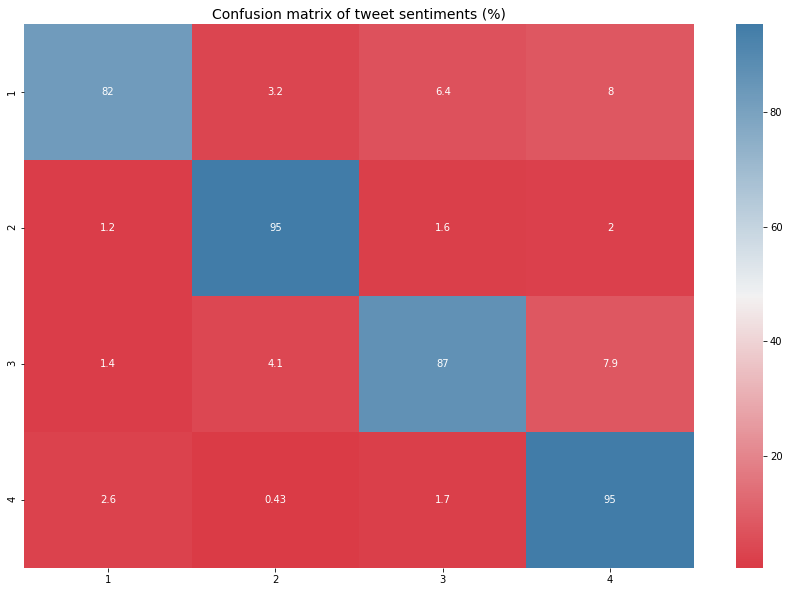

In [16]:
tsa_confusion_matrix = metrics.confusion_matrix(all_predictions, y_raw)
tsa_confusion_matrix = tsa_confusion_matrix.astype(float)

for i in range(len(tsa_confusion_matrix)):
    tsa_confusion_matrix[i] = numpy.true_divide(tsa_confusion_matrix[i], tsa_confusion_matrix[i].sum())*100

cm_df = pandas.DataFrame(tsa_confusion_matrix,
                     index = [i for i in '1234'],
                     columns = [i for i in '1234'])

pyplot.figure(figsize = (15, 10))
cmap = seaborn.diverging_palette(10, 240, n=9, as_cmap=True)
seaborn.heatmap(cm_df, annot=True, cmap=cmap)

pyplot.title('Confusion matrix of tweet sentiments (%)', fontsize=14)
pyplot.show()